In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Input
source_dataset_mat=loadmat('Source_BZ_DG_GG.mat')
source_dataset_raw=np.vstack((source_dataset_mat['BZ'],source_dataset_mat['DG'],source_dataset_mat['GG']))
target_dataset_mat=loadmat('Target_BZ_DG_GG.mat')
target_dataset_raw=np.vstack((target_dataset_mat['BZ'],target_dataset_mat['DG'],target_dataset_mat['GG']))

In [3]:
# Labels
y_source=np.hstack((0*np.ones(160),1*np.ones(160),2*np.ones(160))).astype(np.int64)
y_target=np.hstack((0*np.ones(50),1*np.ones(50),2*np.ones(50))).astype(np.int64)

In [4]:
print(source_dataset_raw.shape)
print(target_dataset_raw.shape)
print(y_source.shape)
print(y_target.shape)

(480, 128)
(150, 128)
(480,)
(150,)


### DRCA

In [5]:
class DRCA():
    '''
    The DRCA Class
    '''
    def __init__(self, n_components = 2,alpha = None, mode = 'raw'):
        '''
        The function to initialize the DRCA class
        :param n_components: The intended dimensionality of projection hyperplane smaller than the initial dimensionality
        :param alpha: weighting factor for target domain data within class scatter
        :param mode: the mode of DRCA:
            'raw': consider source domain data (S) and target domain data (T) as two groups
            'number': consider type-specific source domain data and target domain data based on the average number of cases in S and T
            'mean': equal weights for each class
        '''
        self.mode = mode
        self.Sw_s = None
        self.Sw_t = None
        self.mu_s = None
        self.mu_t = None
        self.alpha = alpha
        self.D_tilde = n_components
    pass

    def fit(self, Xs, Xt, Ys=None, Yt = None):
        '''
        This function fit the DRCA model with the data and labels given by users
        :param Xs: the feature matrix of shape (Ns, D) in source domain, np.array
        :param Xt: the feature matrix of shape (Nt, D) in target domain, np.array
        :param Ys: the label of the data of shape (Ns,) in source domain, np.array, int
        :param Yt: the label of the data of shape (Nt,) in target domain, np.array, int
        '''
        ### --- Summarize statistics --- ###
        if self.mode != 'raw':
            Ys = Ys.reshape(-1,) #we need to use Y and make sure the Y is the intended form
            Yt = Yt.reshape(-1,)
        Ns = Xs.shape[0]
        Nt = Xt.shape[0]
        D = Xs.shape[1]
        
        ### --- Within-domain scatter --- ###
        self.mu_s = np.mean(Xs,axis=0,keepdims=True) #1*D
        self.mu_t = np.mean(Xt,axis=0,keepdims=True)
        self.Sw_s = (Xs - self.mu_s).T @ (Xs - self.mu_s) #D*D
        self.Sw_t = (Xt - self.mu_t).T @ (Xt - self.mu_t) #D*D
        if self.alpha == None:
            self.alpha = Ns/Nt
        self.nominator = self.Sw_s + self.Sw_t * self.alpha
        
        ### --- Eliminate sensor drifts --- ###
        if self.mode == 'raw': #S and T as two entities
            self.denominator = (self.mu_s - self.mu_t).T @ (self.mu_s-self.mu_t) #D*D
        elif self.mode == 'number': #Focus on the same classes appeared in target domain
            Kt = np.unique(Yt).shape[0] #Assume that the target domain classes are fewer 
            self.denominator = np.empty((D,D))
            for i in range(Kt):
                Ns = np.mean(Ys==Kt[i])
                Nt = np.mean(Yt==Kt[i])
                N = 0.5*(self.Ns+self.Nt)#self. ???????????????????
                mu_s_matrix = np.mean(Xs[Ys==Kt[i],:],axis=0,keepdims=True)
                mu_t_matrix = np.mean(Xt[Yt==Kt[i],:],axis=0,keepdims=True)
                Sb_matrix = (self.mu_s_matrix-self.mu_t_matrix).T @ (self.mu_s_matrix-self.mu_t_matrix)
                self.denomiator += N * Sb_matrix
        elif self.mode == 'mean': #Equal weights for every class
            Kt = np.unique(Yt).shape[0] #Assume that the target domain classes are fewer 
            self.denominator = np.empty((D,D))
            for i in range(Kt):
                mu_s_matrix = np.mean(Xs[Ys==Kt[i],:],axis=0,keepdims=True)#1*D
                mu_t_matrix = np.mean(Xt[Yt==Kt[i],:],axis=0,keepdims=True)#1*D
                Sb_matrix = (self.mu_s_matrix-self.mu_t_matrix).T @ (self.mu_s_matrix-self.mu_t_matrix)
                self.denomiator += Sb_matrix#D*D
        
        
        eigenValues, eigenVectors = np.linalg.eig(np.linalg.pinv(self.denominator) @ self.nominator) #D*D

        idx = np.abs(eigenValues).argsort()[::-1]  
        self.eigenValues = eigenValues[idx]
        self.eigenVectors = eigenVectors[:,idx]
        self.W = self.eigenVectors[:,0:self.D_tilde]#shape=(D,D_tilde)
    pass    
        
    def transform(self, X):
        '''
        This function use the fitted SRLDA model
        :param X: the data in np.array of shape (N,D) that needs to be projected to the lower dimension
        :return: X_tilde: the projected data in the lower dimensional space in np.array of shape (N, D_tilde)
        '''
        return np.matmul(X,self.W)   #goal:  (N,D_tilde)      (D_tilde*D)@(D*N).T     (N*D)(D*D_tilde)
    pass
    
    def fit_transform(self, Xs, Xt, Ys=None, Yt = None):
        '''
        :param Xs: the feature matrix of shape (Ns, D) in source domain, np.array
        :param Xt: the feature matrix of shape (Nt, D) in target domain, np.array
        :param Ys: the label of the data of shape (Ns,) in source domain, np.array, int
        :param Yt: the label of the data of shape (Nt,) in target domain, np.array, int '''
                                                  
        self.fit(Xs, Xt, Ys, Yt)
        return np.real(self.transform(Xs)),np.real(self.transform(Xt)) #N * D_tilde
    pass

### Spilt Dataset

In [6]:
class HerbalData(Dataset):
    def __init__(self, x_train, y_train):
        assert len(x_train) == len(y_train)
        self.x = x_train
        self.y = y_train
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [7]:
# Without DRCA
x_train, x_valid, y_train, y_valid = train_test_split(source_dataset_raw, y_source, train_size=0.7, random_state=1)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, train_size=0.5, random_state=1)
train_set = HerbalData(torch.from_numpy(x_train).to(device), torch.from_numpy(y_train).to(device))
valid_set = HerbalData(torch.from_numpy(x_valid).to(device), torch.from_numpy(y_valid).to(device))
test_set = HerbalData(torch.from_numpy(x_test).to(device), torch.from_numpy(y_test).to(device))
target_set = HerbalData(torch.from_numpy(target_dataset_raw).to(device), torch.from_numpy(y_target).to(device))

train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=128)
target_dataloader = DataLoader(target_set, batch_size=128)

print("Train Set:", x_train.shape)
print("Valid Set:", x_valid.shape)
print("Test Set:", x_test.shape)
print("Target Set:", target_dataset_raw.shape)

Train Set: (336, 128)
Valid Set: (72, 128)
Test Set: (72, 128)
Target Set: (150, 128)


In [8]:
# With DRCA
drca=DRCA(n_components=50, alpha=10)#n_components and alpha value are hyperparameters
source_dataset_drca, target_dataset_drca = drca.fit_transform(source_dataset_raw,target_dataset_raw)

x_train_drca, x_valid_drca, y_train_drca, y_valid_drca = train_test_split(source_dataset_drca, y_source, train_size=0.7, random_state=1)
x_valid_drca, x_test_drca, y_valid_drca, y_test_drca = train_test_split(x_valid_drca, y_valid_drca, train_size=0.5, random_state=1)
train_set_drca = HerbalData(torch.from_numpy(x_train_drca).to(device), torch.from_numpy(y_train_drca).to(device))
valid_set_drca = HerbalData(torch.from_numpy(x_valid_drca).to(device), torch.from_numpy(y_valid_drca).to(device))
test_set_drca = HerbalData(torch.from_numpy(x_test_drca).to(device), torch.from_numpy(y_test_drca).to(device))
target_set_drca = HerbalData(torch.from_numpy(target_dataset_drca).to(device), torch.from_numpy(y_target).to(device))

train_dataloader_drca = DataLoader(train_set_drca, batch_size=128, shuffle=True)
valid_dataloader_drca = DataLoader(valid_set_drca, batch_size=128, shuffle=True)
test_dataloader_drca = DataLoader(test_set_drca, batch_size=128)
target_dataloader_drca = DataLoader(target_set_drca, batch_size=128)
print("Train Set:", x_train_drca.shape)
print("Valid Set:", x_valid_drca.shape)
print("Test Set:", x_test_drca.shape)
print("Target Set:", target_dataset_drca.shape)

Train Set: (336, 50)
Valid Set: (72, 50)
Test Set: (72, 50)
Target Set: (150, 50)


### CNN-1D

In [9]:
class CNN1d(nn.Module):
    def __init__(self, input_dim, n_filters, filter_sizes, strides, output_dim, dropout):
        
        super().__init__()
        
        convs = []
        in_channel = 1
        conv_dim = input_dim
        for i in range(len(n_filters)):
            convs.append(nn.Conv1d(in_channels=in_channel, 
                                   out_channels=n_filters[i], 
                                   kernel_size=filter_sizes[i],
                                   stride=strides[i])
                         )
            convs.append(nn.MaxPool1d(kernel_size=4, stride=1))
            in_channel = n_filters[i]
            conv_dim = int((conv_dim - filter_sizes[i])/strides[i] + 1) - 3
            
        self.convs = nn.Sequential(*convs)
        
        self.flatten = nn.Flatten()
        
        self.fc = nn.Sequential(
            nn.Linear(conv_dim*n_filters[-1], 32),
            nn.Linear(32, output_dim),
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, data):
        
        # data = [batch size, input_dim]
        
        data = data.unsqueeze(1)
        
        conved = self.convs(data)
        
        #conved_n = [batch size, n_filters]
        
        conved = self.dropout(conved)
        
        output = self.fc(self.flatten(conved))
            
        return output

In [10]:
INPUT_DIM = x_train.shape[1]
INPUT_DIM_DRCA = x_train_drca.shape[1]
N_FILTERS = [32, 64]
FILTER_SIZES = [2, 2]
STRIDES = [1, 1]
OUTPUT_DIM = 3
DROPOUT = 0.5

model = CNN1d(INPUT_DIM, N_FILTERS, FILTER_SIZES, STRIDES, OUTPUT_DIM, DROPOUT)
model.double()
model = model.to(device)
optimizer = optim.Adam(model.parameters())

model_drca = CNN1d(INPUT_DIM_DRCA, N_FILTERS, FILTER_SIZES, STRIDES, OUTPUT_DIM, DROPOUT)
model_drca.double()
model_drca = model_drca.to(device)
optimizer_drca = optim.Adam(model_drca.parameters())

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [11]:
def train(model, train_dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_f1 = 0
    batches = len(train_dataloader)
    
    model.train()
    
    for _, batch in enumerate(train_dataloader):
        x, y = batch
        
        optimizer.zero_grad()
        
        predictions = model(x)
        
        loss = criterion(predictions, y)
        
        predictions = torch.argmax(torch.softmax(predictions, 0), dim=1)
        acc = torchmetrics.functional.accuracy(predictions, y)
        prec, recall = torchmetrics.functional.precisixon_recall(predictions, y, num_classes=3, average='macro')
        f1 = torchmetrics.functional.f1(predictions, y, num_classes=3, average='macro')
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_prec += prec.item()
        epoch_recall += recall.item()
        epoch_f1 += f1.item()

    return epoch_loss / batches, epoch_acc / batches, epoch_prec / batches, epoch_recall / batches, epoch_f1 / batches

In [12]:
def evaluate(model, test_dataloader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_f1 = 0
    batches = len(test_dataloader)
    
    model.eval()
    
    with torch.no_grad():
    
        for _, batch in enumerate(test_dataloader):
            x, y = batch

            predictions = model(x)
            
            loss = criterion(predictions, y)
            
            predictions = torch.argmax(torch.softmax(predictions, 0), dim=1)
            acc = torchmetrics.functional.accuracy(predictions, y)
            prec, recall = torchmetrics.functional.precision_recall(predictions, y, num_classes=3, average='macro')
            f1 = torchmetrics.functional.f1(predictions, y, num_classes=3, average='macro')

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_prec += prec.item()
            epoch_recall += recall.item()
            epoch_f1 += f1.item()
        
    return epoch_loss / batches, epoch_acc / batches, epoch_prec / batches, epoch_recall / batches, epoch_f1 / batches

### Training Model Without DRCA

In [13]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:
N_EPOCHS = 30

train_loss = np.zeros(N_EPOCHS)
train_acc = np.zeros(N_EPOCHS)
train_prec = np.zeros(N_EPOCHS)
train_recall = np.zeros(N_EPOCHS)
train_f1 = np.zeros(N_EPOCHS)

valid_loss = np.zeros(N_EPOCHS)
valid_acc = np.zeros(N_EPOCHS)
valid_prec = np.zeros(N_EPOCHS)
valid_recall = np.zeros(N_EPOCHS)
valid_f1 = np.zeros(N_EPOCHS)


best_valid_loss = float('inf')

for i in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss[i], train_acc[i], train_prec[i], train_recall[i], train_f1[i] = train(model, train_dataloader, optimizer, criterion)
    valid_loss[i], valid_acc[i], valid_prec[i], valid_recall[i], valid_f1[i] = evaluate(model, valid_dataloader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss[i] < best_valid_loss:
        best_valid_loss = valid_loss[i]
        torch.save(model.state_dict(), 'cnn-agg.pt')
    
    print(f'Epoch: {i+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss[i]:.3f} | Train Acc: {train_acc[i]*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss[i]:.3f} |  Val. Acc: {valid_acc[i]*100:.2f}%')

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 13.830 | Train Acc: 41.04%
	 Val. Loss: 14.980 |  Val. Acc: 43.06%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 13.101 | Train Acc: 49.58%
	 Val. Loss: 10.554 |  Val. Acc: 44.44%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 6.536 | Train Acc: 57.08%
	 Val. Loss: 2.684 |  Val. Acc: 55.56%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.906 | Train Acc: 37.71%
	 Val. Loss: 3.223 |  Val. Acc: 31.94%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 1.765 | Train Acc: 44.58%
	 Val. Loss: 1.728 |  Val. Acc: 51.39%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 1.753 | Train Acc: 58.49%
	 Val. Loss: 1.815 |  Val. Acc: 43.06%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 1.430 | Train Acc: 56.67%
	 Val. Loss: 0.604 |  Val. Acc: 50.00%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.458 | Train Acc: 59.58%
	 Val. Loss: 0.854 |  Val. Acc: 58.33%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.885 | Train Acc: 57.08%
	 Val. Loss: 0.888 |  Val. Acc: 58.33%
Epoch: 10 | Epoch Time: 

## Analysis

In [27]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

def predict(model, x):
    x = torch.from_numpy(x).to(device)
    with torch.no_grad():
        return torch.argmax(torch.softmax(model(x), 0), dim=1).cpu().detach().numpy()

def confusion_matrix_plot(y_pred, y_true):
    cm = confusion_matrix(y_pred, y_true, normalize='true')
    normalize = True
    cmap = 'RdPu'
    classes = [0, 1, 2]
    title = 'cofusion matrix'
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax = ax)
    ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), xticklabels = classes, yticklabels = classes, ylabel = 'True label', xlabel = 'Predicted label', title = title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right', rotation_mode = 'anchor')
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha = 'center', va = 'center', color = 'white' if cm[i,j] > thresh else 'black')
            fig.tight_layout()

def metric_epoch(train_loss, valid_loss, train_f1, valid_f1):
    x = range(0, len(train_loss))
    plt.figure(figsize=(14,3))
    grid = plt.GridSpec(3, 2, wspace=0.5, hspace=0.5)
    plt.subplot(grid[:,0])
    plt.plot(x, train_f1, color="r", marker='o',markersize='1.5',markeredgecolor='r',markeredgewidth = 1.5, label = 'Train F1 score')
    plt.plot(x, valid_f1, color="b", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Valid F1 score')
    plt.legend()
    plt.title('F1 score vs epoches')
    plt.xlabel('epoches')
    plt.ylabel('F1 score')
    plt.subplot(grid[:,1])
    plt.plot(x, train_loss, color="red", marker='o',markersize='1.5',markeredgecolor='r',markeredgewidth = 1.5, label = 'Train Loss')
    plt.plot(x, valid_loss, color="blue", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Valid Loss')
    plt.legend()
    plt.title('Loss vs epoches')
    plt.xlabel('epoches')
    plt.ylabel('Loss')
    plt.show()

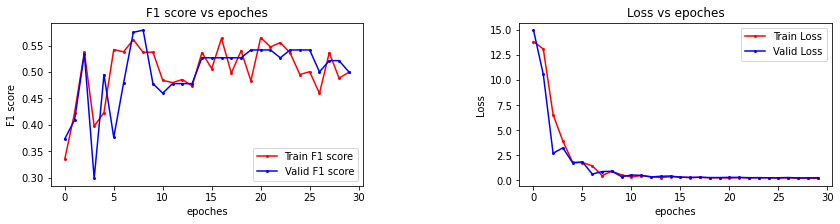

In [28]:
metric_epoch(train_loss, valid_loss, train_f1, valid_f1)

### Test Set

In [17]:
model.load_state_dict(torch.load('cnn-agg.pt'))

test_loss, test_acc, test_prec, test_recall, test_f1 = evaluate(model, test_dataloader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Prec: {test_prec*100:.2f}% | Test Recall: {test_recall*100:.2f}% | Test F1: {test_f1*100:.2f}%')

Test Loss: 0.157 | Test Acc: 66.67% | Test Prec: 82.22% | Test Recall: 63.60% | Test F1: 58.87%


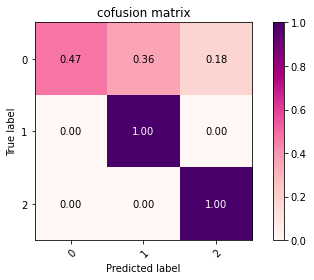

In [18]:
confusion_matrix_plot(predict(model, x_test), y_test)

### Target Set

In [19]:
model.load_state_dict(torch.load('cnn-agg.pt'))

test_loss, test_acc, test_prec, test_recall, test_f1 = evaluate(model, target_dataloader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Prec: {test_prec*100:.2f}% | Test Recall: {test_recall*100:.2f}% | Test F1: {test_f1*100:.2f}%')

Test Loss: 7.051 | Test Acc: 11.90% | Test Prec: 22.17% | Test Recall: 6.61% | Test F1: 8.29%


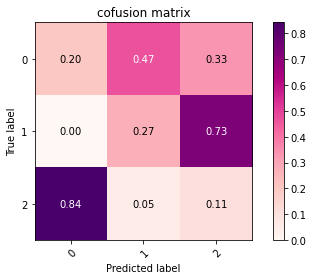

In [20]:
confusion_matrix_plot(predict(model, target_dataset_raw), y_target)

### Training Model With DRCA

In [21]:
N_EPOCHS = 40

best_valid_loss = float('inf')
train_loss_drca = np.zeros(N_EPOCHS)
train_acc_drca = np.zeros(N_EPOCHS)
train_prec_drca = np.zeros(N_EPOCHS)
train_recall_drca = np.zeros(N_EPOCHS)
train_f1_drca = np.zeros(N_EPOCHS)

valid_loss_drca = np.zeros(N_EPOCHS)
valid_acc_drca = np.zeros(N_EPOCHS)
valid_prec_drca = np.zeros(N_EPOCHS)
valid_recall_drca = np.zeros(N_EPOCHS)
valid_f1_drca = np.zeros(N_EPOCHS)


for i in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss_drca[i], train_acc_drca[i], train_prec_drca[i], train_recall_drca[i], train_f1_drca[i] = train(model_drca,
                                                                                                              train_dataloader_drca,
                                                                                                              optimizer_drca,
                                                                                                              criterion)
    valid_loss_drca[i], valid_acc_drca[i], valid_prec_drca[i], valid_recall_drca[i], valid_f1_drca[i] = evaluate(model_drca,
                                                                                                                 valid_dataloader_drca,
                                                                                                                 criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss_drca[i] < best_valid_loss:
        best_valid_loss = valid_loss_drca[i]
        torch.save(model_drca.state_dict(), 'cnn-agg-drca.pt')
    
    print(f'Epoch: {i+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_drca[i]:.3f} | Train Acc: {train_acc_drca[i]*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss_drca[i]:.3f} |  Val. Acc: {valid_acc_drca[i]*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.122 | Train Acc: 46.15%
	 Val. Loss: 1.109 |  Val. Acc: 79.17%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 1.082 | Train Acc: 60.31%
	 Val. Loss: 0.978 |  Val. Acc: 79.17%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.948 | Train Acc: 64.74%
	 Val. Loss: 0.922 |  Val. Acc: 79.17%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.950 | Train Acc: 70.89%
	 Val. Loss: 0.831 |  Val. Acc: 76.39%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.857 | Train Acc: 71.88%
	 Val. Loss: 0.793 |  Val. Acc: 76.39%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.803 | Train Acc: 70.05%
	 Val. Loss: 0.754 |  Val. Acc: 70.83%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.736 | Train Acc: 69.11%
	 Val. Loss: 0.657 |  Val. Acc: 61.11%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.677 | Train Acc: 71.15%
	 Val. Loss: 0.601 |  Val. Acc: 58.33%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.638 | Train Acc: 67.19%
	 Val. Loss: 0.551 |  Val. Acc: 54.17%
Epoch: 10 | Epoch Time: 0m 0

### Test Set

## Analysis

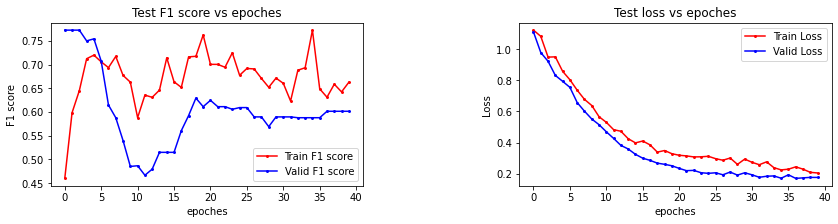

In [22]:
metric_epoch(train_loss_drca, valid_loss_drca, train_f1_drca, valid_f1_drca)

In [23]:
model_drca.load_state_dict(torch.load('cnn-agg-drca.pt'))

test_loss, test_acc, test_prec, test_recall, test_f1 = evaluate(model_drca, test_dataloader_drca, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Prec: {test_prec*100:.2f}% | Test Recall: {test_recall*100:.2f}% | Test F1: {test_f1*100:.2f}%')

Test Loss: 0.149 | Test Acc: 70.83% | Test Prec: 83.33% | Test Recall: 71.00% | Test F1: 70.07%


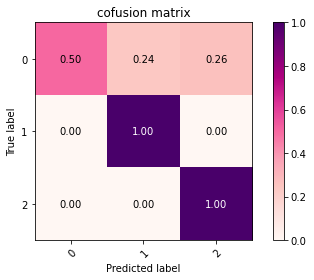

In [24]:
confusion_matrix_plot(predict(model_drca, x_test_drca), y_test_drca)

### Target Set

In [25]:
model_drca.load_state_dict(torch.load('cnn-agg-drca.pt'))

test_loss, test_acc, test_prec, test_recall, test_f1 = evaluate(model_drca, target_dataloader_drca, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Prec: {test_prec*100:.2f}% | Test Recall: {test_recall*100:.2f}% | Test F1: {test_f1*100:.2f}%')

Test Loss: 6.023 | Test Acc: 43.11% | Test Prec: 47.86% | Test Recall: 27.98% | Test F1: 31.87%


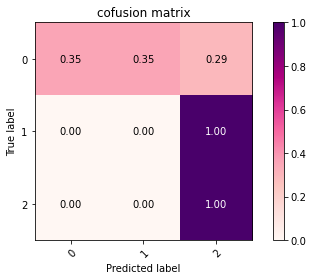

In [26]:
confusion_matrix_plot(predict(model_drca, target_dataset_drca), y_target)